# SVM算法

主要是SMO(序列最小化优化算法)的实现

In [1]:
%matplotlib inline

import numpy as np
import random
import math
from matplotlib import pyplot as plt

In [2]:
'''
load dataset
parameter:
    file_path: dataset's path
'''
def load_dataset(file_path):
    context = []
    with open(file_path, 'r') as fp:
        for line in fp.readlines():
            line = line.strip()
            data = [float(ele) for ele in line.split('\t')]
            context.append(data)
            
    context = np.array(context)
    return context[:,:2], context[:, 2].astype(np.int8)

'''
random select second alpha
parameter:
    i: first alpha index
    m: number of alpha
'''
def select_second_alpha(i, m):
    j = i
    while (j == i):
        j = random.uniform(0, m)
    return j

In [3]:
'''
draw raw data
parameter:
    data: raw_data
    labels: labels
'''
def draw_raw_data(data, labels):
    pos_data = data[labels==1, :]
    neg_data = data[labels==-1, :]
    
    plt.scatter(pos_data[:,0], pos_data[:,1], color='g')
    plt.scatter(neg_data[:,0], neg_data[:,1], color='r')

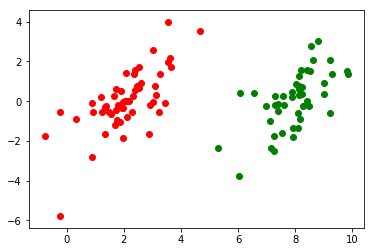

In [4]:
data_file_path = './testSet.txt'
data, labels = load_dataset(data_file_path)
draw_raw_data(data, labels)

## SMO算法（简单版本）

1. 先选择一个$\alpha$，之后再在剩余的$\alpha$中选择另一个组成对
2. 计算Ei和Ej
3. 根据公式更新对应的alpha
4. 随后更新b

在对$\alpha$更新的时候，注意
1. 当$\alpha \in (0, C]$时，样本为正确分类或者支持向量，此时Ei应该很小或者大于0的，所以违反这个的话，要被更新
2. 当$\alpha \in [0, C)$时，样本为错误分类或者支持向量，此时Ei应该很小或者小于0的，所以违反这个的话，要被更新

In [5]:
'''
Kij
parameter:
    v1: vector1
    v2: vector2
'''
def getKij(v1, v2):
    return np.sum(v1*v2)

'''
gxi, this is the hypre planar
parameter:
    data_mat: dataset matrix
    labels: labels array
    alpha: the array of alpha
    b: the model's b
    i: index of the alpha
'''
def gxi(data_mat, labels, alpha, b, i):
    i = int(i)
    Ki = np.dot(data_mat, data_mat[i, :].T).squeeze()
    return np.sum(alpha * labels * Ki) + b

'''
gxi, this is the hypre planar
parameter:
    data_mat: dataset matrix
    labels: labels array
    alpha: the array of alpha
    b: the model's b
    i: index of the alpha
'''
def SMO_simple(dataset, labels, C, toler, max_iter):
    n, m = dataset.shape
    alpha = np.zeros(n, np.float)
    b = 0
    it = 0
    # loop for enough times
    while (it < max_iter):
        alpha_change = 0
        # outer loop select every alpha
        for i in range(n):
            gx_i = gxi(dataset, labels, alpha, b, i)
            Ei = gx_i - labels[i]
            if all([labels[i]*Ei < -toler, alpha[i] < C]) or \
               all([labels[i]*Ei > toler,  alpha[i] > 0]):
                j = int(select_second_alpha(i, n))
                gx_j = gxi(dataset, labels, alpha, b, j)
                Ej = gx_j - labels[j]
                
                old_alpha_i = alpha[i]
                old_alpha_j = alpha[j]
                
                if labels[i] != labels[j]:
                    L = max(0, alpha[j]-alpha[i])
                    H = min(C, C+alpha[j]-alpha[i])
                else:
                    L = max(0, alpha[i]+alpha[j]-C)
                    H = min(C, alpha[i]+alpha[j])
                
                if L==H:
                    continue
                
                Kii = getKij(dataset[i,:], dataset[i,:])
                Kjj = getKij(dataset[j,:], dataset[j,:])
                Kij = getKij(dataset[i,:], dataset[j,:])
                eta = 2*Kij - Kii - Kjj
                if eta >= 0:
                    continue
                alpha[j] -= labels[j]*(Ei-Ej)/eta
                alpha[j] = max(L, alpha[j])
                alpha[j] = min(H, alpha[j])
                
                if abs(alpha[j] - old_alpha_j) < 0.0001:
                    print("j need not change!!!")
                    continue
                # update alpha_i
                alpha[i] += labels[j]*labels[i]*(old_alpha_j - alpha[j])
                
                # update b
                b1 = b - Ei - labels[i]*(alpha[i] - old_alpha_i)*Kii - labels[j]*(alpha[j] - old_alpha_j)*Kij
                b2 = b - Ej - labels[i]*(alpha[i] - old_alpha_i)*Kij - labels[j]*(alpha[j] - old_alpha_j)*Kjj
                
                if all([alpha[i]>0, alpha[i]<C]):
                    b = b1
                elif all([alpha[j]>0, alpha[j]<C]):
                    b = b2
                else:
                    b = (b1+b2)/2
                alpha_change+=1
                print("iter {} i: {} change time {}".format(it, i, alpha_change))
        if alpha_change == 0:
            it += 1
        else:
            it = 0
            
    return alpha, b

In [6]:
alpha, b = SMO_simple(data, labels, 0.6, 0.01, 30)

iter 0 i: 2 change time 1
iter 0 i: 5 change time 2
j need not change!!!
j need not change!!!
j need not change!!!
j need not change!!!
j need not change!!!
iter 0 i: 29 change time 3
j need not change!!!
j need not change!!!
j need not change!!!
j need not change!!!
j need not change!!!
j need not change!!!
j need not change!!!
j need not change!!!
j need not change!!!
j need not change!!!
iter 1 i: 2 change time 1
iter 1 i: 5 change time 2
iter 1 i: 8 change time 3
j need not change!!!
j need not change!!!
iter 1 i: 23 change time 4
j need not change!!!
j need not change!!!
j need not change!!!
j need not change!!!
j need not change!!!
j need not change!!!
iter 1 i: 52 change time 5
j need not change!!!
iter 1 i: 55 change time 6
j need not change!!!
j need not change!!!
j need not change!!!
j need not change!!!
j need not change!!!
j need not change!!!
j need not change!!!
j need not change!!!
j need not change!!!
j need not change!!!
j need not change!!!
j need not change!!!
iter 0

j need not change!!!
j need not change!!!
j need not change!!!
j need not change!!!
j need not change!!!
j need not change!!!
j need not change!!!
j need not change!!!
j need not change!!!
j need not change!!!
j need not change!!!
j need not change!!!
j need not change!!!
j need not change!!!
j need not change!!!
j need not change!!!
j need not change!!!
j need not change!!!
j need not change!!!
j need not change!!!
j need not change!!!
j need not change!!!
j need not change!!!
j need not change!!!
j need not change!!!
iter 13 i: 55 change time 1
j need not change!!!
j need not change!!!
j need not change!!!
j need not change!!!
j need not change!!!
j need not change!!!
j need not change!!!
j need not change!!!
j need not change!!!
j need not change!!!
j need not change!!!
j need not change!!!
j need not change!!!
j need not change!!!
j need not change!!!
j need not change!!!
j need not change!!!
iter 6 i: 17 change time 1
j need not change!!!
j need not change!!!
j need not change!!!


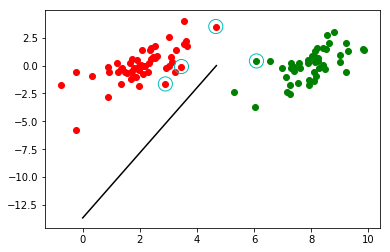

In [8]:
'''
draw support vector
parameter:
    data: all dataset
    labels: all labels
    alpha: SMO's output
    C: loosen parameter
'''
def draw_support_vector(data, labels, alpha, b, C):
    n, m = data.shape
    
    pos_data = data[labels==1, :]
    neg_data = data[labels==-1, :]
    
    plt.scatter(pos_data[:,0], pos_data[:,1], color='g')
    plt.scatter(neg_data[:,0], neg_data[:,1], color='r')
    
    supports = np.nonzero((alpha>0) * (alpha<C))[0]
    plt.scatter(data[supports, 0], data[supports, 1], color='', edgecolors='c', marker='o', s=200)
    
    ay = alpha*labels
    w = np.sum(data*ay.reshape(-1,1), axis=0)
    
    x1 = [0,       -b/w[0]]
    x2 = [-b/w[1],       0]
    plt.plot(x1, x2, 'k')
    
draw_support_vector(data, labels, alpha, b, 0.6)

## 完整版的SMO

在简单版本中，SMO方法通过遍历所有的alpha来形成alpha对，但是实际上，这是可以通过一些策略来加速寻找要优化的alpha对
1. 外层循环找到第一个$\alpha1$，其满足的条件为违反KKT条件
2. 根据$alpha1$得到Ei，之后找到与之距离最大的Ej，得到j
3. 运行更新程序

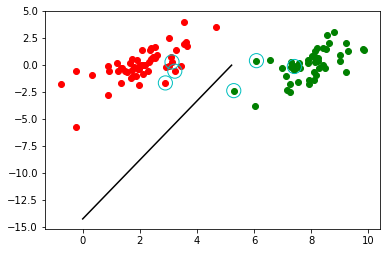

In [48]:
'''
structure: store the parameter need to be update
'''
class SMO:
    def __init__(self, data, labels, C, toler):
        self.X = data
        self.Y = labels
        self.C = C
        self.toler = toler
        self.n = data.shape[0]
        self.alpha = np.zeros(self.n)
        self.b = 0
        self.Ecache = np.zeros((self.n, 2))

'''
find the second alpha index
'''
def select_second_J(i, oS, Ei):
    best_j = -1
    best_Ej = 0
    best_delta = 0
    # mark alpha i
    oS.Ecache[i, 0] = 1
    oS.Ecache[i, 1] = Ei
    valid_set = np.nonzero(oS.Ecache[:, 0])[0]
    if len(valid_set)>1:
        for j in valid_set:
            j = int(j)
            if j == i:
                continue
            Ej = gxi(data_mat=oS.X, labels=oS.Y, alpha=oS.alpha, b=oS.b, i=j) - oS.Y[j]
            delta_E = abs(Ei - Ej)
            if delta_E > best_delta:
                best_delta = delta_E
                best_Ej = Ej
                best_j = j
        return best_j, best_Ej
    else:
        j = int(select_second_alpha(i, oS.n))
        Ej = gxi(data_mat=oS.X, labels=oS.Y, alpha=oS.alpha, b=oS.b, i=j) - oS.Y[j]
        return int(j), Ej
    
'''
update oS
'''
def updateOS(i, oS):
    Ei = gxi(data_mat=oS.X, labels=oS.Y, alpha=oS.alpha, b=oS.b, i=i) - oS.Y[i]
    oS.Ecache[i, 0] = 1 
    oS.Ecache[i, 1] = Ei
    
'''
inner loop
'''
def inner_loop(i, oS):
    Ei = gxi(data_mat=oS.X, labels=oS.Y, alpha=oS.alpha, b=oS.b, i=i) - oS.Y[i]
    if all([labels[i]*Ei < -oS.toler, oS.alpha[i] < oS.C]) or \
       all([labels[i]*Ei >  oS.toler, oS.alpha[i] > 0]):
        j, Ej = select_second_J(i, oS, Ei)
        old_alpha_i = oS.alpha[i]
        old_alpha_j = oS.alpha[j]

        if oS.Y[i] != oS.Y[j]:
            L = max(0, oS.alpha[j] - oS.alpha[i])
            H = min(oS.C, oS.C + oS.alpha[j] - oS.alpha[i])
        else:
            L = max(0, oS.alpha[i] + oS.alpha[j] - oS.C)
            H = min(oS.C, oS.alpha[i] + oS.alpha[j])

        if L==H:
            return 0

        Kii = getKij(oS.X[i,:], oS.X[i,:])
        Kjj = getKij(oS.X[j,:], oS.X[j,:])
        Kij = getKij(oS.X[i,:], oS.X[j,:])
        eta = 2*Kij - Kii - Kjj
        if eta >= 0:
            return 0
        alpha_j = oS.alpha[j] - oS.Y[j]*(Ei-Ej)/eta
        alpha_j = max(L, alpha_j)
        alpha_j = min(H, alpha_j)
        if abs(alpha_j - old_alpha_j) < 0.0001:
            return 0
        
        oS.alpha[j] = alpha_j
        updateOS(j, oS)
        # update alpha_i
        oS.alpha[i] += oS.Y[j]*oS.Y[i]*(old_alpha_j - oS.alpha[j])
        updateOS(i, oS)
        # update b
        b1 = oS.b - Ei - oS.Y[i]*(oS.alpha[i] - old_alpha_i)*Kii - oS.Y[j]*(oS.alpha[j] - old_alpha_j)*Kij
        b2 = oS.b - Ej - oS.Y[i]*(oS.alpha[i] - old_alpha_i)*Kij - oS.Y[j]*(oS.alpha[j] - old_alpha_j)*Kjj

        if all([oS.alpha[i]>0, oS.alpha[i]<oS.C]):
            oS.b = b1
        elif all([oS.alpha[j]>0, oS.alpha[j]<oS.C]):
            oS.b = b2
        else:
            oS.b = (b1+b2)/2
        return 1
    else:
        return 0
    
'''
SMO complete
parameter:
    dataset: dataset
    labels: labels
    C: loosen 
    toler: toler
'''
def SMOP(dataset, labels, C, toler, max_iter):
    oS = SMO(dataset, labels, C, toler)
    ite = 0
    entire_set = True
    alpha_change = 0
    #  and (alpha_change > 0 or entire_set)
    while (ite < max_iter) and ((alpha_change > 0) or (entire_set)):
        alpha_change = 0 
        if entire_set:
            for i in range(oS.n):
                alpha_change += inner_loop(i, oS)
                # print(">>> full loop: iter {}:{} pair changed {}".format(ite, i, alpha_change))
            ite += 1
        else:
            supports = np.nonzero((oS.alpha>0)*(oS.alpha<C))[0]
            for k in supports:
                alpha_change += inner_loop(k, oS)
                # print(">>> non loop: iter {}:{} pair changed {}".format(ite, k, alpha_change))
            ite += 1
        # loop support vectors after loop all set
        if entire_set:
            entire_set = False
        elif alpha_change == 0:
            # if all support vector not change
            entire_set = True
            
    return oS.alpha, oS.b

alpha, b = SMOP(data, labels, 0.6, 0.001, 40)
draw_support_vector(data, labels, alpha, b, 0.6)